# Exploring Magnetic Reconnection
## Heliophysics Summer School - Magnetic Reconnection Lab
---

**Goals:**


1.   Understand the major features of "fast" magnetic reconnection.
2.   Examine the unique features of reconnection in the dayside and nightside magnetosphere.
3.   Engage with spacecraft measurement methods and reconstruction/identification of reconnection regions.

---

## Introduction

In [1]:
%pip install -qU "airavata-python-sdk[notebook]"
import airavata_jupyter_magic

%authenticate

# PLEASE NOTE: At a given time, ONLY run a single job in one of the available clusters: Anvil OR Jetstream. 
# Anvil is the default cluster and if you need to run on Jetstream; comment the Anvil and uncomment the Jetstream
# Anvil
%request_runtime test_cpu --file=cybershuttle.yml --group=Gkeyll --walltime=60 --use=AnvilCPU:shared
# Jetstream
# %request_runtime test_cpu --file=cybershuttle.yml --group=Gkeyll --walltime=60 --use=Gkeyll:cloud

%wait_for_runtime test_cpu --live
%switch_runtime test_cpu

Note: you may need to restart the kernel to use updated packages.

Loaded airavata_jupyter_magic (2.2.3) 
(current runtime = local)

  %authenticate                              -- Authenticate to access high-performance runtimes.
  %request_runtime <rt> [args]               -- Request a runtime named <rt> with configuration <args>.
                                                Call multiple times to request multiple runtimes.
  %restart_runtime <rt>                      -- Restart runtime <rt> if it hangs. This will clear all variables.
  %stop_runtime <rt>                         -- Stop runtime <rt> when no longer needed.
  %wait_for_runtime <rt>                     -- Wait for runtime <rt> to be ready.
  %switch_runtime <rt>                       -- Switch the active runtime to <rt>. All subsequent cells will run here.
  %%run_on <rt>                              -- Force a cell to always execute on <rt>, regardless of the active runtime.
  %stat_runtime <rt>                     

Output()

Authenticated.

Requesting runtime=test_cpu...
[AnvilCPU:shared, 60 Minutes, 1 Node(s), 4 CPU(s), 1 GPU(s), 4096 MB RAM, 1024 MB VRAM]
* modules=[]
* libraries=['python=3.11', 'pip']
* pip=['numpy', 'matplotlib', 'postgkyl']
* mounts=[]
* links={}
Requested runtime=test_cpu
Request successful: runtime=test_cpu


Output()

local:/tmp/connection_yp342w48.json --> test_cpu:connection_yp342w48.json... [200]
started proc_name=test_cpu_kernel on rt=test_cpu. pid=208945
forwarding ports=[14610, 14611, 14612, 14613, 14614]
test_cpu:14610 -> access via 18.118.140.230:10000
test_cpu:14611 -> access via 18.118.140.230:10001
test_cpu:14612 -> access via 18.118.140.230:10002
test_cpu:14613 -> access via 18.118.140.230:10003
test_cpu:14614 -> access via 18.118.140.230:10004
started ipykernel tunnels for test_cpu at 18.118.140.230
started ipykernel client for test_cpu
Remote Jupyter kernel launched and connected for runtime=test_cpu.
Switched to runtime=test_cpu.


In [2]:
!find ~/cybershuttle/dataset/Plasma-Vlab-amitava-class/ -mindepth 1 -maxdepth 1 -type d -exec ln -s {} . \;

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [3]:
# Import python packages
import matplotlib
import matplotlib.pyplot as plt
import postgkyl as pg
import numpy as np

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [4]:
# Helper function for computing vector potential
def calc_psi2d(fx, fy, dx=1, dy=1):#solenoidal flows
	'''
	Calcualte psi by integrating dpsi = -fy*dx + fx*dy, psi[0,0]=0.
	Notes: 
		1. (fx=dpsi/dy,fy=-dpsi/dx) is called Hamiltonian gradient of psi, and	contours of psi give vector field (fx, fy);
		2. div(f)=0
	'''
	ny,nx=fx.shape
	psi=np.zeros((ny,nx))
	for jx in range(1,nx):
		psi[0,jx]=psi[0,jx-1]-fy[0,jx]*dx
	for jy in range(1,ny):
		psi[jy,:]=psi[jy-1,:]+fx[jy,:]*dy
	# since f = rot(A) gives extra restraints on f (e.g., div(f)=0)
	# it makes sense that information provided by fy[1:nx,:] is useless here
	return psi

# Helper function for finding X-points
def find_saddles(mat : np.ndarray) -> list:                                                                                                                              
    (N, M) = mat.shape                                                                     
                                                                                           
    jMax = np.argmax(mat, axis = 1) # index of col for max in each row                     
    iMin = np.argmin(mat, axis = 0) # index of row for min in each col                     
                                                                                           
    IJMax = [(i,jMax[i]) for i in range(N)] # list of indexes of max of each row           
    IJMin = [(iMin[j],j) for j in range(M)] # list of indexes of min of each col           
                                                                                           
    maxRowMinCol = list(set(IJMax) & set(IJMin)) # max of row, min of col                         
                                                                                           
    iMax = np.argmax(mat, axis = 0) # index of row for max in each col                     
    jMin = np.argmin(mat, axis = 1) # index of col for min in each row                     
                                                                                           
    IJMax = [(iMax[j],j) for j in range(M)] # list of indexes of max of each col           
    IJMin = [(i,jMin[i]) for i in range(N)] # list of indexes of min of each row           
                                                                                           
    minRowMaxCol = list(set(IJMax) & set(IJMin)) # min of row, max of col                                                                                          
    
    return maxRowMinCol + minRowMaxCol  

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


### $\texttt{Gkeyll}$ and $\texttt{postgkyl}$

The code we will be using to model magnetic reconnection is [$\texttt{Gkeyll}$](https://gkeyll.readthedocs.io/), a general purpose simulation framework for a variety of fluid and plasma systems. You can download and install $\texttt{Gkeyll}$ yourself by following the installation instructions on our [Github repo](https://github.com/ammarhakim/gkylzero). 

To read the data, we will utilize the post-processing suite we have developed alongside $\texttt{Gkeyll}$, [$\texttt{postgkyl}$](https://github.com/ammarhakim/postgkyl), which you can also download and install via the instructions on Github. The cluster we will be utilizing for analyzing the results of our simulations already has installations of $\texttt{Gkeyll}$ and $\texttt{postgkyl}$; we already imported postgkyl in this Jupyter Notebook, so if we did not have $\texttt{postgkyl}$, that import command would not have worked! 

The output of $\texttt{Gkeyll}$ simulations can be manipulated in one of two ways: through the GData class, which retains useful metadata from the simulation to subsequent operations, or by directly fetching the raw values and grid and storing them in Numpy arrays for our subsequent manipulations. We will utilize both means of reading the data as we analyze our simulation results. 

In [5]:
def get_Gdata(pre, frame):
    data_elc = pg.data.GData("%s-elc_%d.gkyl" % (pre, frame))
    data_ion = pg.data.GData("%s-ion_%d.gkyl" % (pre, frame))
    data_field = pg.data.GData("%s-field_%d.gkyl" % (pre, frame))

    return data_elc, data_ion, data_field

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [6]:
def read_data(data_elc, data_ion, data_field):
    fluid_elc = data_elc.get_values()
    fluid_ion = data_ion.get_values()  
    field = data_field.get_values()  

    # Same grid for all electrons, ions, and EM fields
    coords = data_elc.get_grid()
    # Center the grid values
    for d in range(len(coords)):
        coords[d] = 0.5*(coords[d][:-1] + coords[d][1:])

    return coords, fluid_elc, fluid_ion, field

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


## Part 1: Fast Magnetic Reconnection

Magnetic reconnection that occurs in the magnetosphere is "fast"; that is, it occurs at time scales much shorter than the estimates captured by models such as Sweet-Parker and ideal magnetohydrodynamics (MHD). What are these models missing?

1.   MHD cannot get fast reconnection. We have to add at least two-fluid effects to include dispersive waves. 
2.   Sweet-Parker assumes resistivity sets the $\delta/L$ scaling. 
3.   The layer is not genuinely incompressible. We need compressibility so that the plasma can shock and push plasma in the outflow. 
4.   The conservation of energy argument is missing additional energy flux terms which move energy into the layer.

Using ten-moment two-fluid simulation data, we will explore the features of fast reconnection.

**We have written out the data every $\Delta t_{IO} = 0.5 \Omega_{ci}^{-1}$ to time $t_{end} = 30 \Omega_{ci}^{-1}$ for a total of 60 frames**.

In [7]:
# Physical constants and derived parameters
gas_gamma = 5.0 / 3.0 # Adiabatic index.
epsilon0 = 1.0 # Permittivity of free space.
mu0 = 1.0 # Permeability of free space.
light_speed = 1.0/np.sqrt(epsilon0*mu0) # Speed of light. 
mass_ion = 100.0 # Ion mass.
charge_ion = 1.0 # Ion charge.
mass_elc = 1.0 # Electron mass.
charge_elc = -1.0 # Electron charge.
Ti_over_Te = 5.0 # Ion temperature / electron temperature.
n0 = 1.0 # Reference number density.
nb_over_n0 = 0.2 # Background number density / reference number density.
wpi = np.sqrt(charge_ion**2 * n0 / (epsilon0 * mass_ion)) # Ion plasma frequency. 
wpe = np.sqrt(charge_ion**2 * n0 / (epsilon0 * mass_elc)) # Electron plasma frequency. 
di = light_speed/wpi # Ion inertial length. 
de = light_speed/wpe # Electron inertial length. 
B0 = 0.5 # Reference magnetic field strength. Sets ratio of vAe/c. 
beta = 1.0 # Plasma beta.
omega_ci = charge_ion * B0 / mass_ion # Ion cyclotron frequency. 
vA0 = B0/np.sqrt(mu0*n0*mass_ion) # Reference Alfven speed. 
vA_up = B0/np.sqrt(mu0*nb_over_n0*mass_ion) # Upstream reference Alfven speed from background density. 
Lambda_ee = 2.0e5 # Plasma parameter for computing collision time. 
Ti_frac = Ti_over_Te / (1.0 + Ti_over_Te) # Fraction of total temperature from ions.
Te_frac = 1.0 / (1.0 + Ti_over_Te) # Fraction of total temperature from electrons.
T_tot = beta * (B0 * B0) / 2.0 / n0 # Total temperature.
T_elc_ref = T_tot*Te_frac # Reference electron temperature. 

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [8]:
# Frame of simulation data (0-60)
frame = 60

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [9]:
# Load data - re-run if changing frame
data_elc, data_ion, data_field = get_Gdata("10m_gem_mass100/rt_10m_gem", frame)
r_coords, r_fluid_elc, r_fluid_ion, r_field = read_data(data_elc, data_ion, data_field)

# Compute out-of-plane current density
Nx = r_fluid_ion.shape[0]
Ny = r_fluid_ion.shape[1]
Jz = np.zeros((Nx, Ny))
Jz = charge_ion/mass_ion*r_fluid_ion[...,3] + charge_elc/mass_elc*r_fluid_elc[...,3]
n_e = r_fluid_elc[...,0]
n_i = r_fluid_ion[...,0]
ux_e = r_fluid_elc[...,1]/r_fluid_elc[...,0]
uy_e = r_fluid_elc[...,2]/r_fluid_elc[...,0]
ux_i = r_fluid_ion[...,1]/r_fluid_ion[...,0]
uy_i = r_fluid_ion[...,2]/r_fluid_ion[...,0]

# Compute contours of the magnetic field.
Ex = r_field[...,0]
Ey = r_field[...,1]
Ez = r_field[...,2]
Bx = r_field[...,3]
By = r_field[...,4]
Bz = r_field[...,5]
dx = r_coords[0][1] - r_coords[0][0]
dy = r_coords[1][1] - r_coords[1][0]
psi = np.zeros((Ny, Nx))
psi = calc_psi2d(Bx.transpose(),By.transpose(), dx, dy)

# Compute magnitude of the magnetic field
_, magB_sq = pg.tools.mag_sq(data_field, '3:6')
magB = np.sqrt(magB_sq[...,0])

# Compute local Alfven speed
_, rho_ion = pg.tools.get_density(data_ion)
vA = magB/np.sqrt(mu0*rho_ion[...,0])

# Compute normalized drift speed
coords, ux =  pg.tools.get_vx(data_ion)
coords, uy = pg.tools.get_vy(data_ion)
ux_norm0 = ux[...,0]/vA_up # Normalized x flow to upstream Alfven speed
uy_norm0 = uy[...,0]/vA_up

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [10]:
# Reconnection layer

# Color plots - only activate one!
show_Jz = 1 # Out-of-plane current
show_Bz = 0 # Out-of-plane magnetic field
show_Ez = 0 # Out-of-plane electric field
show_magB = 0 # Magnetic field magnitude
show_vA = 0 # Alfven speed
show_jets = 0 # Ion jets

# Streamlines
show_psi = 1 # Vector potential
show_ue = 0 # Electron drifts
show_ui = 0 # Ion drifts

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


executing cell on test_cpu...
waiting for cell to finish on test_cpu...


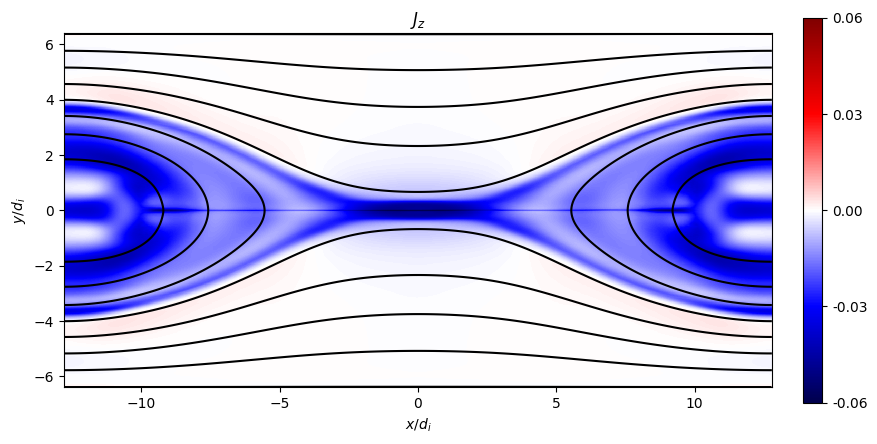

cell finished on test_cpu.


In [11]:
# Plot quantities - re-run to plot new quantities
plt.figure(figsize=(10,5))
# Add shading='gouraud' for further interpolation and smoother plots
if show_Jz == True:
    vmax = np.max(np.abs(Jz))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Jz.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$J_z$')
if show_Bz == True:
    vmax = np.max(np.abs(Bz))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Bz.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$B_z$')
if show_Ez == True:
    vmax = np.max(np.abs(Ez))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Ez.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$E_z$')
if show_magB == True:
    vmax = np.max(np.abs(magB))
    vmin = 0.0
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, magB.transpose(), vmax=vmax, vmin=vmin, cmap='inferno')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$|\mathbf{B}|$')
if show_vA == True:
    vmax = np.max(np.abs(vA))
    vmin = 0.0
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, vA.transpose(), vmax=vmax, vmin=vmin, cmap='inferno')#, shading='gouraud')
    plt.colorbar(format='%.1f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$v_A$')
if show_jets == True:
    vmax = np.max(np.abs(ux_norm0))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, ux_norm0.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.1f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$u_x/v_A$')
    
X, Y = np.meshgrid(r_coords[0]/di, r_coords[1]/di)
if show_psi == True:
    plt.contour(r_coords[0]/di, r_coords[1]/di, psi, 7, colors="k", linestyles="solid")
if show_ue == True:
    plt.streamplot(X, Y, ux_e.transpose(), uy_e.transpose(), color='green', density=1.0)
if show_ui == True:
    plt.streamplot(X, Y, ux_i.transpose(), uy_i.transpose(), color='blue', density=0.7, broken_streamlines=True)
plt.xlabel(r'$x/d_i$')
plt.ylabel(r'$y/d_i$')
plt.setp(plt.gca(), aspect=1.0)
plt.show()

In [12]:
# Profiles across the reconnection layer
show_Bx = 1
show_Jz = 1
show_uy = 1
show_ne = 0
show_ni = 0

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


executing cell on test_cpu...
waiting for cell to finish on test_cpu...


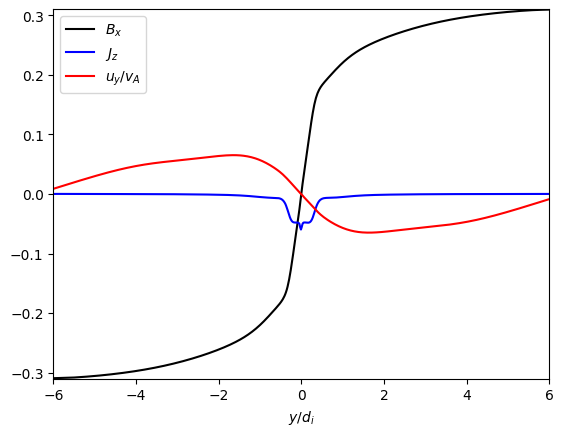

cell finished on test_cpu.


In [13]:
# Plot at x=0
x0 = int(Nx/2)
plt.figure()
ymax = 0.0
ymin = 0.0
if show_Bx == True:
    plt.plot(r_coords[1]/di, Bx[x0,...], 'k', label=r'$B_x$')
    ymax = max(np.max(np.abs(Bx[x0,...])), ymax)
    ymin = -ymax
if show_Jz == True:
    plt.plot(r_coords[1]/di, Jz[x0,...], 'b', label=r'$J_z$')
    ymax = max(np.max(np.abs(Jz[x0,...])), ymax)
    ymin = -ymax
if show_uy == True:
    plt.plot(r_coords[1]/di, uy_norm0[x0,...], 'r', label=r'$u_y/v_A$')
    ymax = max(np.max(np.abs(uy_norm0[x0,...])), ymax)
    ymin = -ymax
if show_ne == True:
    plt.plot(r_coords[1]/di, n_e[x0,...], 'y', label=r'$n_e$')
    ymax = max(np.max(np.abs(n_e[x0,...])), ymax)
    ymin = min(0.0, ymin)
if show_ni == True:
    plt.plot(r_coords[1]/di, n_i[x0,...], 'r', label=r'$n_i$')
    ymax = max(np.max(np.abs(n_i[x0,...])), ymax)
    ymin = min(0.0, ymin)

plt.xlabel(r'$y/d_i$')
plt.xlim(-6.0, 6.0)
plt.ylim(ymin, ymax)
plt.legend(loc='best')
plt.show()

#### Reconnection Rate

The reconnection rate is the rate of magnetic flux transfer occuring due to reconnection. We can compute this by either evaluating the reconnecting electric field $E_z$ at the X-point, or computing the rate of change of the vector potential.

executing cell on test_cpu...
waiting for cell to finish on test_cpu...


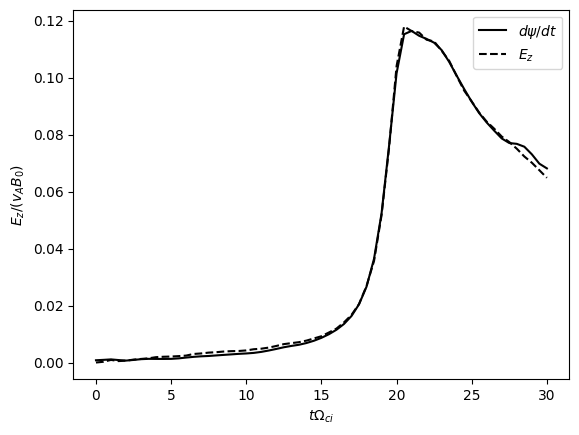

cell finished on test_cpu.


In [14]:
# Compute the reconnection rate
def compute_flux(pre, frame): 
    data_elc, data_ion, data_field = get_Gdata(pre, frame)
    r_coords, r_fluid_elc, r_fluid_ion, r_field = read_data(data_elc, data_ion, data_field)
    # Compute vector potential at X point.
    dx = r_coords[0][1] - r_coords[0][0]
    dy = r_coords[1][1] - r_coords[1][0]
    psi = np.zeros((Ny, Nx))
    psi = calc_psi2d(r_field[...,3].transpose(), r_field[...,4].transpose(), dx, dy)
    saddles = find_saddles(psi)
    psiX = psi[saddles[0][0], saddles[0][1]]
    psi0 = np.max(np.abs(psi))
    # Fetch Ez at X point
    EzX = r_field[saddles[0][1], saddles[0][0], 2]
    return psiX, psi0, EzX
    
num_frames = 61
psiX_10m = np.zeros(num_frames)
psi0_10m = np.zeros(num_frames)
EzX_10m = np.zeros(num_frames)
t = np.linspace(0, 30/omega_ci, num_frames)
rate_fac = 1/(B0*vA_up)
for i in range(0, num_frames):
    # Compute the flux at the X-point in 10 moment simulation
    psiX_10m[i], psi0_10m[i], EzX_10m[i] = compute_flux("10m_gem_mass100/rt_10m_gem", i) 

# We can either use Ez or the time derivative of the vector potential psi to estimate the reconnection rate. 
psi_diff_10m = np.abs(psi0_10m - psiX_10m)
dpsi_dt_10m = np.gradient(psi_diff_10m, t)
plt.figure()
plt.plot(t*omega_ci, np.abs(dpsi_dt_10m)*rate_fac, 'k-', label=r'$d\psi/dt$')
plt.plot(t*omega_ci, np.abs(EzX_10m)*rate_fac, 'k--', label=r'$E_z$')
plt.xlabel(r'$t \Omega_{ci}$')
plt.ylabel(r'$E_z/(v_A B_0)$')
plt.legend(loc='best')
plt.show()

## Part 2: Symmetric and Asymmetric Reconnection in the Magnetosphere

### Nightside Reconnection (Magnetotail)

#### Activity

Examine the nightside reconnection layer. What differences do you see with the previous example? What is contributing to these differences?

In [15]:
# Physical constants and derived parameters
epsilon0 = 1.0 # Permittivity of free space.
mu0 = 1.0 # Permeability of free space.
light_speed = 1.0/np.sqrt(epsilon0*mu0) # Speed of light. 
mass_ion = 1.0 # Ion mass.
charge_ion = 1.0 # Ion charge.
mass_elc = 1.0/256.0 # Electron mass.
charge_elc = -1.0 # Electron charge.
Ti_over_Te = 5.0 # Ion temperature / electron temperature.
n0 = 1.0 # Reference number density.
nb_over_n0 = 0.1 # Background number density / reference number density.
ve = 0.017*light_speed
vA0 = ve*np.sqrt(mass_elc/mass_ion*2.0*(1 + Ti_over_Te))
wpi = np.sqrt(charge_ion**2 * n0 / (epsilon0 * mass_ion)) # Ion plasma frequency. 
wpe = np.sqrt(charge_ion**2 * n0 / (epsilon0 * mass_elc)) # Electron plasma frequency. 
di = light_speed/wpi # Ion inertial length. 
de = light_speed/wpe # Electron inertial length. 
B0 = vA0*np.sqrt(mu0*n0*mass_ion) # Reference magnetic field strength. Sets ratio of vAe/c. 
Bg = 0.1*B0
beta = 1.0 # Plasma beta.
omega_ci = charge_ion * B0 / mass_ion # Ion cyclotron frequency. 
Ti_frac = Ti_over_Te / (1.0 + Ti_over_Te) # Fraction of total temperature from ions.
Te_frac = 1.0 / (1.0 + Ti_over_Te) # Fraction of total temperature from electrons.
T_tot = beta * (B0 * B0) / 2.0 / n0 # Total temperature.
T_elc_ref = T_tot*Te_frac # Reference electron temperature. 

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [16]:
# Frame of simulation data (0-25)
frame = 20

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [17]:
# Load data - re-run if changing frame
data_elc, data_ion, data_field = get_Gdata("10m_magnetotail/10m_magnetotail", frame)
r_coords, r_fluid_elc, r_fluid_ion, r_field = read_data(data_elc, data_ion, data_field)

# Compute out-of-plane current density
Nx = r_fluid_ion.shape[0]
Ny = r_fluid_ion.shape[1]
Jz = np.zeros((Nx, Ny))
Jz = charge_ion/mass_ion*r_fluid_ion[...,3] + charge_elc/mass_elc*r_fluid_elc[...,3]
n_e = r_fluid_elc[...,0]
n_i = r_fluid_ion[...,0]
ux_e = r_fluid_elc[...,1]/r_fluid_elc[...,0]
uy_e = r_fluid_elc[...,2]/r_fluid_elc[...,0]
ux_i = r_fluid_ion[...,1]/r_fluid_ion[...,0]
uy_i = r_fluid_ion[...,2]/r_fluid_ion[...,0]

# Compute contours of the magnetic field.
Ex = r_field[...,0]
Ey = r_field[...,1]
Ez = r_field[...,2]
Bx = r_field[...,3]
By = r_field[...,4]
Bz = r_field[...,5]
dx = r_coords[0][1] - r_coords[0][0]
dy = r_coords[1][1] - r_coords[1][0]
psi = np.zeros((Ny, Nx))
psi = calc_psi2d(Bx.transpose(),By.transpose(), dx, dy)

# Compute magnitude of the magnetic field
_, magB_sq = pg.tools.mag_sq(data_field, '3:6')
magB = np.sqrt(magB_sq[...,0])

# Compute local Alfven speed
_, rho_ion = pg.tools.get_density(data_ion)
vA = magB/np.sqrt(mu0*rho_ion[...,0])

# Compute normalized drift speed
coords, ux =  pg.tools.get_vx(data_ion)
coords, uy = pg.tools.get_vy(data_ion)
ux_norm0 = ux[...,0]/vA0 # Normalized x flow to upstream Alfven speed
uy_norm0 = uy[...,0]/vA0

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [18]:
# Reconnection layer

# Color plots - only activate one!
show_Jz = 1 # Out-of-plane current
show_Bz = 0 # Out-of-plane magnetic field
show_Ez = 0 # Out-of-plane electric field
show_magB = 0 # Magnetic field magnitude
show_vA = 0 # Alfven speed
show_jets = 0 # Ion jets

# Streamlines
show_psi = 1 # Vector potential
show_ue = 0 # Electron drifts
show_ui = 0 # Ion drifts

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


executing cell on test_cpu...
waiting for cell to finish on test_cpu...


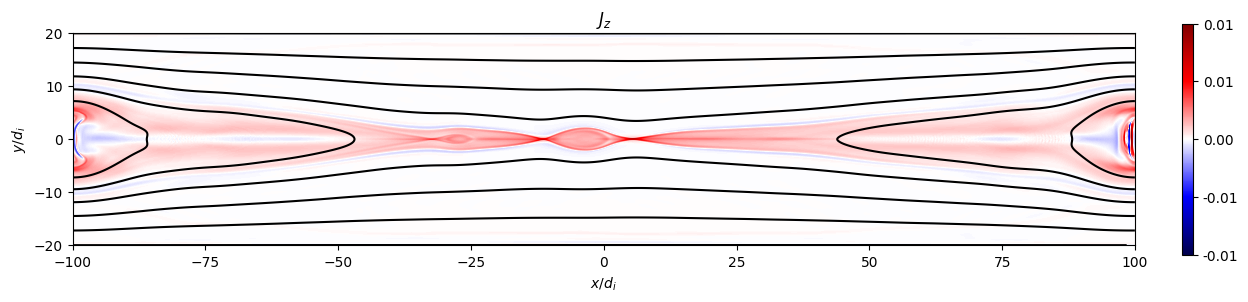

cell finished on test_cpu.


In [19]:
# Plot quantities - re-run to plot new quantities
plt.figure(figsize=(15,3))
# Add shading='gouraud' for further interpolation and smoother plots
if show_Jz == True:
    vmax = np.max(np.abs(Jz))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Jz.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$J_z$')
if show_Ez == True:
    vmax = np.max(np.abs(Ez))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Ez.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$E_z$')
if show_Bz == True:
    vmax = np.max(np.abs(Bz))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Bz.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$B_z$')
if show_magB == True:
    vmax = np.max(np.abs(magB))
    vmin = 0.0
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, magB.transpose(), vmax=vmax, vmin=vmin, cmap='inferno')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$|\mathbf{B}|$')
if show_vA == True:
    vmax = np.max(np.abs(vA))
    vmin = 0.0
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, vA.transpose(), vmax=vmax, vmin=vmin, cmap='inferno')#, shading='gouraud')
    plt.colorbar(format='%.1f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$v_A$')
if show_jets == True:
    vmax = np.max(np.abs(ux_norm0))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, ux_norm0.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.1f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$u_x/v_A$')
    
X, Y = np.meshgrid(r_coords[0]/di, r_coords[1]/di)
if show_psi == True:
    plt.contour(r_coords[0]/di, r_coords[1]/di, psi, 7, colors="k", linestyles="solid")
if show_ue == True:
    plt.streamplot(X, Y, ux_e.transpose(), uy_e.transpose(), color='green', density=1.0)
if show_ui == True:
    plt.streamplot(X, Y, ux_i.transpose(), uy_i.transpose(), color='blue', density=0.7, broken_streamlines=True)
plt.xlabel(r'$x/d_i$')
plt.ylabel(r'$y/d_i$')
plt.setp(plt.gca(), aspect=1.0)
plt.show()

In [20]:
# Profiles across the reconnection layer
show_Bx = 1
show_Jz = 1
show_uy = 1
show_ne = 0
show_ni = 0

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


executing cell on test_cpu...
waiting for cell to finish on test_cpu...


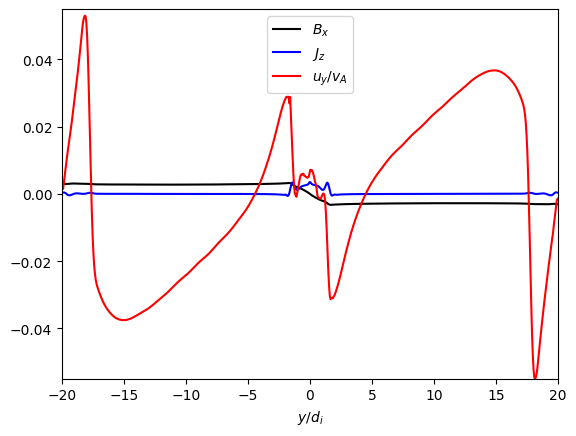

cell finished on test_cpu.


In [21]:
# Plot at x=0
x0 = int(Nx/2)
plt.figure()
ymax = 0.0
ymin = 0.0
if show_Bx == True:
    plt.plot(r_coords[1]/di, Bx[x0,...], 'k', label=r'$B_x$')
    ymax = max(np.max(np.abs(Bx[x0,...])), ymax)
    ymin = -ymax
if show_Jz == True:
    plt.plot(r_coords[1]/di, Jz[x0,...], 'b', label=r'$J_z$')
    ymax = max(np.max(np.abs(Jz[x0,...])), ymax)
    ymin = -ymax
if show_uy == True:
    plt.plot(r_coords[1]/di, uy_norm0[x0,...], 'r', label=r'$u_y/v_A$')
    ymax = max(np.max(np.abs(uy_norm0[x0,...])), ymax)
    ymin = -ymax
if show_ne == True:
    plt.plot(r_coords[1]/di, n_e[x0,...], 'y', label=r'$n_e$')
    ymax = max(np.max(np.abs(n_e[x0,...])), ymax)
    ymin = min(0.0, ymin)
if show_ni == True:
    plt.plot(r_coords[1]/di, n_i[x0,...], 'r', label=r'$n_i$')
    ymax = max(np.max(np.abs(n_i[x0,...])), ymax)
    ymin = min(0.0, ymin)

plt.xlabel(r'$y/d_i$')
plt.xlim(-20.0, 20.0)
plt.ylim(ymin, ymax)
plt.legend(loc='best')
plt.show()

executing cell on test_cpu...
waiting for cell to finish on test_cpu...


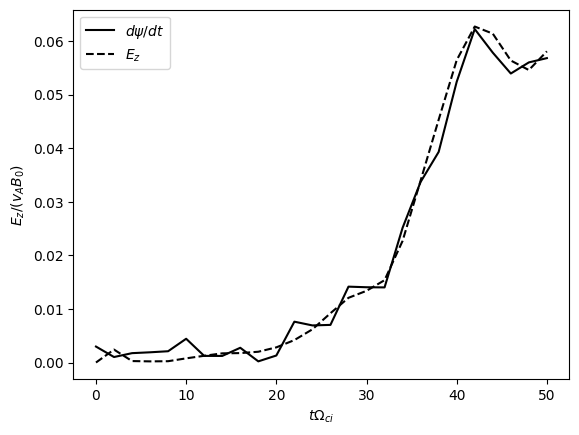

cell finished on test_cpu.


In [22]:
# Compute the reconnection rate
# def compute_flux(pre, frame): 
#     data_elc, data_ion, data_field = get_Gdata(pre, frame)
#     r_coords, r_fluid_elc, r_fluid_ion, r_field = read_data(data_elc, data_ion, data_field)
#     # Compute vector potential at X point.
#     dx = r_coords[0][1] - r_coords[0][0]
#     dy = r_coords[1][1] - r_coords[1][0]
#     psi = np.zeros((Ny, Nx))
#     psi = calc_psi2d(r_field[...,3].transpose(), r_field[...,4].transpose(), dx, dy)
#     saddles = find_saddles(psi)
#     psiX = psi[saddles[0][0], saddles[0][1]]
#     psi0 = np.max(np.abs(psi))
#     # Fetch Ez at X point
#     EzX = r_field[saddles[0][1], saddles[0][0], 2]
#     return psiX, psi0, EzX

# Compute the reconnection rate
def compute_flux(pre, frame): 
    data_elc, data_ion, data_field = get_Gdata(pre, frame)
    r_coords, r_fluid_elc, r_fluid_ion, r_field = read_data(data_elc, data_ion, data_field)
    # Fetch Ez at X point
    EzX = r_field[int(Nx/2), int(Ny/2), 2]
    # Compute vector potential at X point.
    dx = r_coords[0][1] - r_coords[0][0]
    dy = r_coords[1][1] - r_coords[1][0]
    psi = np.zeros((Ny, Nx))
    psi = calc_psi2d(r_field[...,3].transpose(), r_field[...,4].transpose(), dx, dy)
    psiX = psi[int(Ny/2), int(Nx/2)]
    psi0 = np.max(np.abs(psi))        
    return psiX, psi0, EzX
    
num_frames = 26
psiX_10m = np.zeros(num_frames)
psi0_10m = np.zeros(num_frames)
EzX_10m = np.zeros(num_frames)
t = np.linspace(0, 50/omega_ci, num_frames)
rate_fac = 1/(B0*vA0)
for i in range(0, num_frames):
    # Compute the flux at the X-point in 10 moment simulation
    psiX_10m[i], psi0_10m[i], EzX_10m[i] = compute_flux("10m_magnetotail/10m_magnetotail", i) 

# We can either use Ez or the time derivative of the vector potential psi to estimate the reconnection rate. 
psi_diff_10m = np.abs(psi0_10m - psiX_10m)
dpsi_dt_10m = np.gradient(psi_diff_10m, t)
plt.figure()
plt.plot(t*omega_ci, np.abs(dpsi_dt_10m)*rate_fac, 'k-', label=r'$d\psi/dt$')
plt.plot(t*omega_ci, np.abs(EzX_10m)*rate_fac, 'k--', label=r'$E_z$')
plt.xlabel(r'$t \Omega_{ci}$')
plt.ylabel(r'$E_z/(v_A B_0)$')
plt.legend(loc='best')
plt.show()

### Dayside Reconnection (Magnetopause)

#### Activity

Examine the dayside reconnection layer. What differences do you see with the previous example? What is contributing to these differences?

In [23]:
# Physical constants and derived parameters
epsilon0 = 1.0 # Permittivity of free space.
mu0 = 1.0 # Permeability of free space.
light_speed = 1.0/np.sqrt(epsilon0*mu0) # Speed of light. 
mass_ion = 1.0 # Ion mass.
charge_ion = 1.0 # Ion charge.
mass_elc = 1.0/100.0 # Electron mass.
charge_elc = -1.0 # Electron charge.
vAe = 0.2 # Electron Alfven velocity
vAi = vAe*np.sqrt(mass_elc/mass_ion)
n0 = 1.0 # Reference number density.
beta2 = 2.748 # Magnetosheath plasma beta
Ti1_over_Ti2 = 7.73/1.374 # Ion temperature / electron temperature.
Te1_over_Te2 = 1.288/1.374 # Ion temperature / electron temperature.
wpi = np.sqrt(charge_ion**2*n0/(epsilon0*mass_ion)) # Ion plasma frequency. 
wpe = np.sqrt(charge_ion**2*n0/(epsilon0*mass_elc)) # Electron plasma frequency. 
di = light_speed/wpi # Ion inertial length.
de = light_speed/wpe # Electron inertial length.
B0 = vAe*np.sqrt(n0*mass_elc) # Reference magnetic field strength. Sets ratio of vAe/c.
b1 = 1.696*B0
b2 = 1.0*B0
guide1 = 0.099*B0
guide2 = guide1
n1 = 0.062*n0
n2 = 1.0*n0
Ti2 = beta2*(b2*b2)/(2.0*n2*mu0)
Te1 = Ti2*Te1_over_Te2
Ti1 = Ti2*Ti1_over_Ti2
Te2 = (0.5*(b1*b1 - b2*b2) + 0.5*(guide1*guide1 - guide2*guide2) + n1*(Ti1 + Te1) - n2*Ti2)/n2
omega_ci = charge_ion * B0 / mass_ion # Ion cyclotron frequency. 

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [24]:
# Frame of simulation data (0-100)
frame = 60

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [25]:
# Load data - re-run if changing frame
data_elc, data_ion, data_field = get_Gdata("10m_magnetopause/10m_magnetopause", frame)
r_coords, r_fluid_elc, r_fluid_ion, r_field = read_data(data_elc, data_ion, data_field)

# Compute out-of-plane current density
Nx = r_fluid_ion.shape[0]
Ny = r_fluid_ion.shape[1]
Jz = np.zeros((Nx, Ny))
Jz = charge_ion/mass_ion*r_fluid_ion[...,3] + charge_elc/mass_elc*r_fluid_elc[...,3]
n_e = r_fluid_elc[...,0]
n_i = r_fluid_ion[...,0]
ux_e = r_fluid_elc[...,1]/r_fluid_elc[...,0]
uy_e = r_fluid_elc[...,2]/r_fluid_elc[...,0]
ux_i = r_fluid_ion[...,1]/r_fluid_ion[...,0]
uy_i = r_fluid_ion[...,2]/r_fluid_ion[...,0]

# Compute contours of the magnetic field.
Ex = r_field[...,0]
Ey = r_field[...,1]
Ez = r_field[...,2]
Bx = r_field[...,3]
By = r_field[...,4]
Bz = r_field[...,5]
dx = r_coords[0][1] - r_coords[0][0]
dy = r_coords[1][1] - r_coords[1][0]
psi = np.zeros((Ny, Nx))
psi = calc_psi2d(Bx.transpose(),By.transpose(), dx, dy)

# Compute magnitude of the magnetic field
_, magB_sq = pg.tools.mag_sq(data_field, '3:6')
magB = np.sqrt(magB_sq[...,0])

# Compute local Alfven speed
_, rho_ion = pg.tools.get_density(data_ion)
vA = magB/np.sqrt(mu0*rho_ion[...,0])

# Compute normalized drift speed
coords, ux =  pg.tools.get_vx(data_ion)
coords, uy = pg.tools.get_vy(data_ion)
ux_norm0 = ux[...,0]/vAi # Normalized x flow to upstream Alfven speed
uy_norm0 = uy[...,0]/vAi

coords, ux =  pg.tools.get_vx(data_elc)
coords, uy = pg.tools.get_vy(data_elc)
uxe_norm0 = ux[...,0]/vAi # Normalized x flow to upstream Alfven speed
uye_norm0 = uy[...,0]/vAi

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [26]:
# Reconnection layer

# Color plots - only activate one!
show_Jz = 1 # Out-of-plane current
show_Bz = 0 # Out-of-plane magnetic field
show_Ez = 0 # Out-of-plane electric field
show_magB = 0 # Magnetic field magnitude
show_vA = 0 # Alfven speed
show_jets = 0 # Ion jets
show_fast_jet = 0 # Fast electron jet

# Streamlines
show_psi = 1 # Vector potential
show_ue = 0 # Electron drifts
show_ui = 0 # Ion drifts

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


executing cell on test_cpu...
waiting for cell to finish on test_cpu...


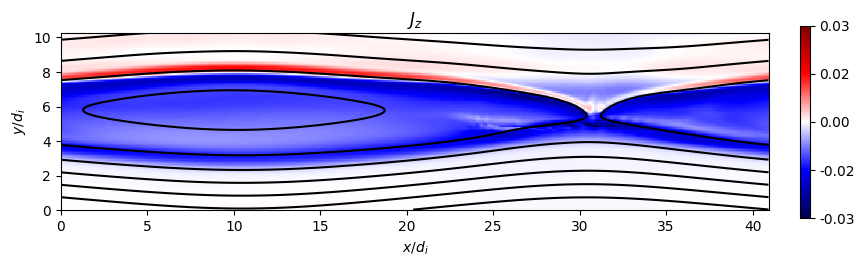

cell finished on test_cpu.


In [27]:
# Plot quantities - re-run to plot new quantities
plt.figure(figsize=(10,2.5))
# Add shading='gouraud' for further interpolation and smoother plots
if show_Jz == True:
    vmax = np.max(np.abs(Jz))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Jz.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$J_z$')
if show_Bz == True:
    vmax = np.max(np.abs(Bz))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Bz.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$B_z$')
if show_Ez == True:
    vmax = np.max(np.abs(Ez))/10.0
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, Ez.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$E_z$')
if show_magB == True:
    vmax = np.max(np.abs(magB))
    vmin = 0.0
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, magB.transpose(), vmax=vmax, vmin=vmin, cmap='inferno')#, shading='gouraud')
    plt.colorbar(format='%.2f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$|\mathbf{B}|$')
if show_vA == True:
    vmax = np.max(np.abs(vA))
    vmin = 0.0
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, vA.transpose(), vmax=vmax, vmin=vmin, cmap='inferno')#, shading='gouraud')
    plt.colorbar(format='%.1f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$v_A$')
if show_jets == True:
    vmax = np.max(np.abs(ux_norm0))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, ux_norm0.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.1f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$u_x/v_A$')
if show_fast_jet == True:
    vmax = np.max(np.abs(uye_norm0))
    vmin = -vmax
    plt.pcolormesh(r_coords[0]/di, r_coords[1]/di, uye_norm0.transpose(), vmax=vmax, vmin=vmin, cmap='seismic')#, shading='gouraud')
    plt.colorbar(format='%.1f', ticks=np.linspace(vmin, vmax, 5), fraction=0.046, pad=0.04)
    plt.title(r'$u_y/v_A$')
    
X, Y = np.meshgrid(r_coords[0]/di, r_coords[1]/di)
if show_psi == True:
    plt.contour(r_coords[0]/di, r_coords[1]/di, psi, 7, colors="k", linestyles="solid")
if show_ue == True:
    plt.streamplot(X, Y, ux_e.transpose(), uy_e.transpose(), color='green', density=1.0)
if show_ui == True:
    plt.streamplot(X, Y, ux_i.transpose(), uy_i.transpose(), color='blue', density=0.7, broken_streamlines=True)
plt.xlabel(r'$x/d_i$')
plt.ylabel(r'$y/d_i$')
plt.ylim([0.0, 10.24])
plt.setp(plt.gca(), aspect=1.0)
plt.show()

In [28]:
# Profiles across the reconnection layer
show_Bx = 1
show_Jz = 1
show_uy = 1
show_ne = 0
show_ni = 0

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


executing cell on test_cpu...
waiting for cell to finish on test_cpu...


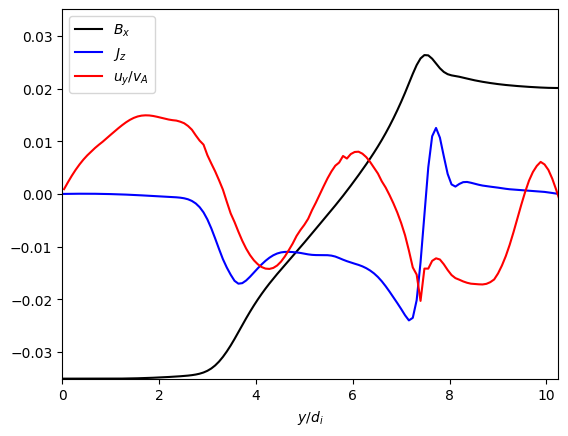

cell finished on test_cpu.


In [29]:
# Plot at x/di=20.48
x0 = int(Nx/2)
plt.figure()
ymax = 0.0
ymin = 0.0
if show_Bx == True:
    plt.plot(r_coords[1]/di, Bx[x0,...], 'k', label=r'$B_x$')
    ymax = max(np.max(np.abs(Bx[x0,...])), ymax)
    ymin = -ymax
if show_Jz == True:
    plt.plot(r_coords[1]/di, Jz[x0,...], 'b', label=r'$J_z$')
    ymax = max(np.max(np.abs(Jz[x0,...])), ymax)
    ymin = -ymax
if show_uy == True:
    plt.plot(r_coords[1]/di, uy_norm0[x0,...], 'r', label=r'$u_y/v_A$')
    ymax = max(np.max(np.abs(uy_norm0[x0,...])), ymax)
    ymin = -ymax
if show_ne == True:
    plt.plot(r_coords[1]/di, n_e[x0,...], 'y', label=r'$n_e$')
    ymax = max(np.max(np.abs(n_e[x0,...])), ymax)
    ymin = min(0.0, ymin)
if show_ni == True:
    plt.plot(r_coords[1]/di, n_i[x0,...], 'r', label=r'$n_i$')
    ymax = max(np.max(np.abs(n_i[x0,...])), ymax)
    ymin = min(0.0, ymin)

plt.xlabel(r'$y/d_i$')
plt.xlim(0.0, 10.24)
plt.ylim(ymin, ymax)
plt.legend(loc='best')
plt.show()

executing cell on test_cpu...
waiting for cell to finish on test_cpu...


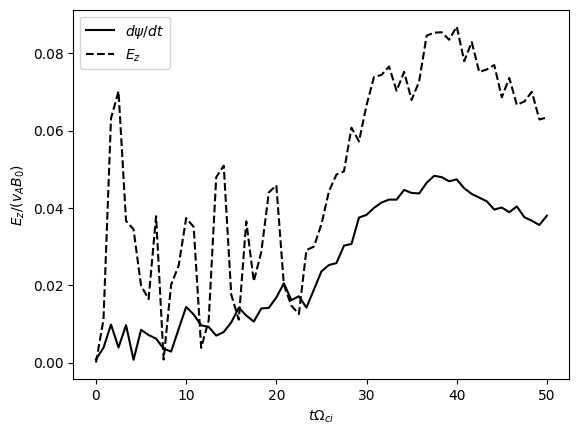

cell finished on test_cpu.


In [30]:
# Compute the reconnection rate
def compute_flux(pre, frame): 
    data_elc, data_ion, data_field = get_Gdata(pre, frame)
    r_coords, r_fluid_elc, r_fluid_ion, r_field = read_data(data_elc, data_ion, data_field)
    # Compute vector potential at X point.
    dx = r_coords[0][1] - r_coords[0][0]
    dy = r_coords[1][1] - r_coords[1][0]
    psi = np.zeros((Ny, Nx))
    psi = calc_psi2d(r_field[...,3].transpose(), r_field[...,4].transpose(), dx, dy)
    saddles = find_saddles(psi)
    psiX = psi[saddles[0][0], saddles[0][1]]
    psi0 = np.min(np.abs(psi))
    # Fetch Ez at X point
    EzX = r_field[saddles[0][1], saddles[0][0], 2]
    return psiX, psi0, EzX
    
num_frames = 61
psiX_10m = np.zeros(num_frames)
psi0_10m = np.zeros(num_frames)
EzX_10m = np.zeros(num_frames)
t = np.linspace(0, 50/omega_ci, num_frames)
rate_fac = 1/(B0*vAi)
for i in range(0, num_frames):
    # Compute the flux at the X-point in 10 moment simulation
    psiX_10m[i], psi0_10m[i], EzX_10m[i] = compute_flux("10m_magnetopause/10m_magnetopause", i)

# We can either use Ez or the time derivative of the vector potential psi to estimate the reconnection rate. 
psi_diff_10m = np.abs(psi0_10m - psiX_10m)
dpsi_dt_10m = np.gradient(psi_diff_10m, t)
plt.figure()
plt.plot(t*omega_ci, np.abs(dpsi_dt_10m)*rate_fac, 'k-', label=r'$d\psi/dt$')
plt.plot(t*omega_ci, np.abs(EzX_10m)*rate_fac, 'k--', label=r'$E_z$')
plt.xlabel(r'$t \Omega_{ci}$')
plt.ylabel(r'$E_z/(v_A B_0)$')
plt.legend(loc='best')
plt.show()

## Part 3: In-Situ Measurement and Identification of Reconnection

We have taken a comprehensive look at the different characteristics of reconnection, but what does reconnection look like to a spacecraft that cannot measure and map out the entire layer?

#### Activity

Ten random spacecraft trajectories have been generated. Using an ID from 0-9, the following script will plot data sampled along that trajectory. In groups, analyze the data associated with your assigned ID and determine:
1. Is this magnetopause or magnetotail reconnection?
2. Where is the X-point?
3. What is the approximate trajectory the spacecraft is taking through the reconnection layer?

In [31]:
# ID number for spacecraft data
group_id = 0

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
cell finished on test_cpu.


In [32]:
# Plot spacecraft data
rd_file = "sc_data/random_%d.npz"
sc_data = np.load(rd_file % group_id)

fig, ax = plt.subplots(6, sharex=True, figsize=(10,8))
ax[0].plot(sc_data['t'], sc_data['bx'], label="$B_L$")
ax[0].plot(sc_data['t'], sc_data['by'], label="$B_M$")
ax[0].plot(sc_data['t'], sc_data['bz'], label="$B_N$")
ax[0].set_ylabel("$B_{LMN}$")
ax[0].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
ax[1].plot(sc_data['t'], sc_data['n'])
ax[1].set_ylabel("$N$")
ax[2].plot(sc_data['t'], sc_data['ux'], label="$u_L$")
ax[2].plot(sc_data['t'], sc_data['uy'], label="$u_N$")
ax[2].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
ax[2].set_ylabel("$u_{i,LMN}$")
ax[3].plot(sc_data['t'], sc_data['uperp_e'], label=r"$u_{e,\perp}$")
ax[3].plot(sc_data['t'], sc_data['uperp_i'], label=r"$u_{i,\perp}$")
ax[3].set_ylabel(r"$u_{\perp}$")
ax[3].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
ax[4].plot(sc_data['t'], sc_data['jz'])
ax[4].set_ylabel("$J_z$")
ax[5].plot(sc_data['t'], sc_data['ex'], label="$E_L$")
ax[5].plot(sc_data['t'], sc_data['ez'], label="$E_M$")
ax[5].plot(sc_data['t'], sc_data['ey'], label="$E_N$")
ax[5].set_ylabel("$E_{LMN}$")
ax[5].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim([0.0, sc_data['t'][-1]])
plt.xlabel('Time (a.u.)')

executing cell on test_cpu...
waiting for cell to finish on test_cpu...
---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
Cell In[31], line 3
      1 # Plot spacecraft data
      2 rd_file = "sc_data/random_%d.npz"
----> 3 sc_data = np.load(rd_file % group_id)
      5 fig, ax = plt.subplots(6, sharex=True, figsize=(10,8))
      6 ax[0].plot(sc_data['t'], sc_data['bx'], label="$B_L$")

File /dev/shm/cybershuttle/envs/f87af6cd/lib/python3.11/site-packages/numpy/lib/npyio.py:427, in load(file, mmap_mode, allow_pickle, fix_imports, encoding, max_header_size)
    425     own_fid = False
    426 else:
--> 427     fid = stack.enter_context(open(os_fspath(file), "rb"))
    428     own_fid = True
    430 # Code to distinguish from NumPy binary files and pickles.

FileNotFoundError: [Errno 2] No such file or directory: 'sc_data/random_0.npz'
cell finished on test_cpu.


#### Discussion

How might you estimate the reconnection rate from the spacecraft data? How well does that estimate compare to the calculations from Part 2?